In [39]:
# https://blog.naver.com/rising_n_falling/222361251972?trackingCode=rss
# https://dynamics-and-control.readthedocs.io/en/latest/2_Control/7_Multivariable_control/Simple%20MPC.html
# https://adityang5.medium.com/model-predictive-control-for-dummies-904c0f7e184d


MPC Model for battery scheduler

Status
    x.0 : pvgn generation
    x.1 : load consumption
    x.2 : grid status
    x.3 : battery soc

Input
    u : amount of charging/discharging

Example 1 : f(x) = x^4 - 4x^3 + 4 x^2 + x -4

In [40]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

def cost_ex1(x):
    print('x', x)
    return x**4 - 4*x**3 + 4*x**2 + x -4

In [41]:
def plt_opt_ex1(res):
    plt.figure(figsize=[4, 3])
    x_val = np.linspace(-1.0, 3.0, 100)
    plt.plot(x_val, cost_ex1(x_val), '--')
    plt.scatter(res.x, cost_ex1(res.x), s=100, c='r', alpha=0.75, marker='o')
    plt.show()
    

x [-0.5]
x [-0.49999999]
x [5.99999982]
x [0.14999998]
x [0.15]
x [0.0003849]
x [0.00038491]
x [-0.15919818]
x [-0.15919817]
x [-0.09985377]
x [-0.09985376]
x [-0.10670738]
x [-0.10670737]
x [-0.10716402]
x [-0.107164]
res  message: Optimization terminated successfully
 success: True
  status: 0
     fun: -4.056172885152515
       x: [-1.072e-01]
     nit: 7
     jac: [-4.435e-05]
    nfev: 15
    njev: 7
x [-1.         -0.95959596 -0.91919192 -0.87878788 -0.83838384 -0.7979798
 -0.75757576 -0.71717172 -0.67676768 -0.63636364 -0.5959596  -0.55555556
 -0.51515152 -0.47474747 -0.43434343 -0.39393939 -0.35353535 -0.31313131
 -0.27272727 -0.23232323 -0.19191919 -0.15151515 -0.11111111 -0.07070707
 -0.03030303  0.01010101  0.05050505  0.09090909  0.13131313  0.17171717
  0.21212121  0.25252525  0.29292929  0.33333333  0.37373737  0.41414141
  0.45454545  0.49494949  0.53535354  0.57575758  0.61616162  0.65656566
  0.6969697   0.73737374  0.77777778  0.81818182  0.85858586  0.8989899
  0.939

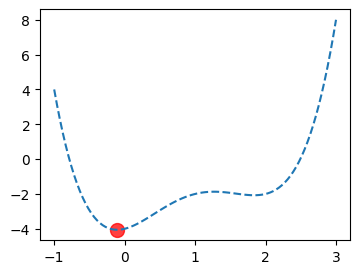

In [42]:
import scipy

x0 = -0.5
res = scipy.optimize.minimize(cost_ex1, x0, method='SLSQP')
print('res', res)
plt_opt_ex1(res)

Example of energy consumption patterns
    Starting temperature for cooling : 20C
    Starting temperature for heating : 15C

In [43]:
import numpy as np 
import pandas as pd

fn = 'sample_data_2.csv'
data = pd.read_csv(fn)
print(data)

    yyyymm  tout  hout    enrg
0   201901  -0.9    46  153161
1   201902   1.0    47  114425
2   201903   7.1    51   89702
3   201904  12.1    51   76987
4   201905  19.4    47   41169
5   201906  22.5    61   71821
6   201907  25.9    69  111422
7   201908  27.2    69  104814
8   201909  22.6    65   63301
9   201910  16.4    62   51085
10  201911   7.6    56   59162
11  201912   1.4    58  118088
12  202001   1.6    56  135882
13  202002   2.5    58   99343
14  202003   7.7    46   93342
15  202004  11.1    50   51873
16  202005  18.0    67   49113
17  202006  23.9    68   67790
18  202007  24.1    77   72170
19  202008  26.5    85  121422
20  202009  21.4    71   70140
21  202010  14.3    61   37515
22  202011   8.0    64   73558
23  202012  -0.3    58  121422
24  202101  -2.4    58  149436


In [44]:
def model(opt_0, y_var, x_var):
    predicted = np.array([])
    for i in range(len(y_var)):
        if x_var[i] < opt_0[0]:
            term = opt_0[2] + opt_0[3] * (opt_0[0] - x_var[i])
        elif x_var[i] > opt_0[1]:
            term = opt_0[2] + opt_0[4] * (x_var[i] - opt_0[1])
        else:
            term = opt_0[2]
        predicted = np.append(predicted, term)
    return predicted

In [45]:
def cost(opt_0, y_var, x_var):
    # print('opt_0', opt_0)
    return np.sum((model(opt_0, y_var, x_var) - y_var) **2)

In [46]:
def constraint(x):
    return x[1]-x[0] - 0.01

In [47]:
def plt_opt_ex2(res_, data_):
    plt.figure(figsize=[4,3])
    xx = np.linspace(data_.tout.min(), data_.tout.max(), 100)
    yy = model(res_.x, xx, xx)
    plt.plot(xx, yy, 'r--')
    plt.scatter(data.tout.values, data.enrg.values, s=100, c='gray')
    plt.show()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3385755946.0919523
            Iterations: 23
            Function evaluations: 212
            Gradient evaluations: 23
[1.37355142e+01 2.00287813e+01 4.47219503e+04 6.18536158e+03
 9.59866530e+03]
3385755946.0919523


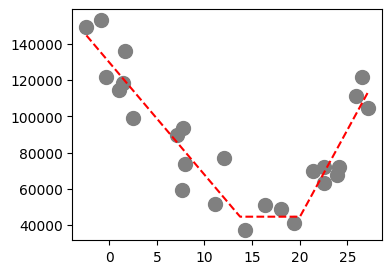

In [48]:
x0 = [8, 20, 60000, 3000, 5000]
tout = data.tout.values 
enrg = data.enrg.values 
con = {'type':'ineq', 'fun':constraint}
bnds = ((-10, 15), (15, 30), (40000, 80000), (4000, 12000), (4000, 12000))

res = scipy.optimize.minimize(cost, x0, args=(enrg, tout), method='SLSQP', options={'disp':True})
# res = scipy.optimize.minimize(cost, x0, constraints=con, bounds=bnds, args=(enrg, tout), method='SLSQP', options={'disp':True})
print(res.x)
print(res.fun)
plt_opt_ex2(res, data)